In [2]:
# IGNORE THIS CELL WHICH CUSTOMIZES LAYOUT AND STYLING OF THE NOTEBOOK !
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None
from IPython.core.display import HTML; HTML(open("custom.html", "r").read())

# Chapter 7: Regression

Regression belongs like classification to the field of supervised learning. 

<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i>&nbsp; 
<strong>Regression predicts numerical values</strong> 
in contrast to classification which predicts categories.
</div>

<img src="https://i.imgflip.com/30416v.jpg" title="made at imgflip.com" width=35%/>

<div class="alert alert-block alert-warning">
<i class="fa fa-info-circle"></i>&nbsp; 
    Other differences are:

* Accuracy is measured differently


* Other algorithms
</div>

## Example: Salmon weight

The dataset `salmon.csv` holds measurements of `circumference`, `length` and `weight` for  `atlantic` and `sockeye` salmons.

Our goal is to predict `weight` based on the other three features.

In [3]:
import pandas as pd

df = pd.read_csv("salmon.csv")
df.head()

,circumference,length,kind,weight
0,25.5,85.5,atlantic,31.2
1,22.5,62.5,atlantic,12.4
2,29.0,88.0,atlantic,34.8
3,32.5,85.5,atlantic,62.7
4,24.5,74.5,atlantic,24.2


In [4]:
df.tail()

,circumference,length,kind,weight
95,19.0,69.5,sockeye,18.8
96,18.5,67.0,sockeye,18.9
97,24.5,67.5,sockeye,24.7
98,21.0,66.5,sockeye,26.0
99,27.5,86.5,sockeye,43.4


Let us inspect the features and their distributions:

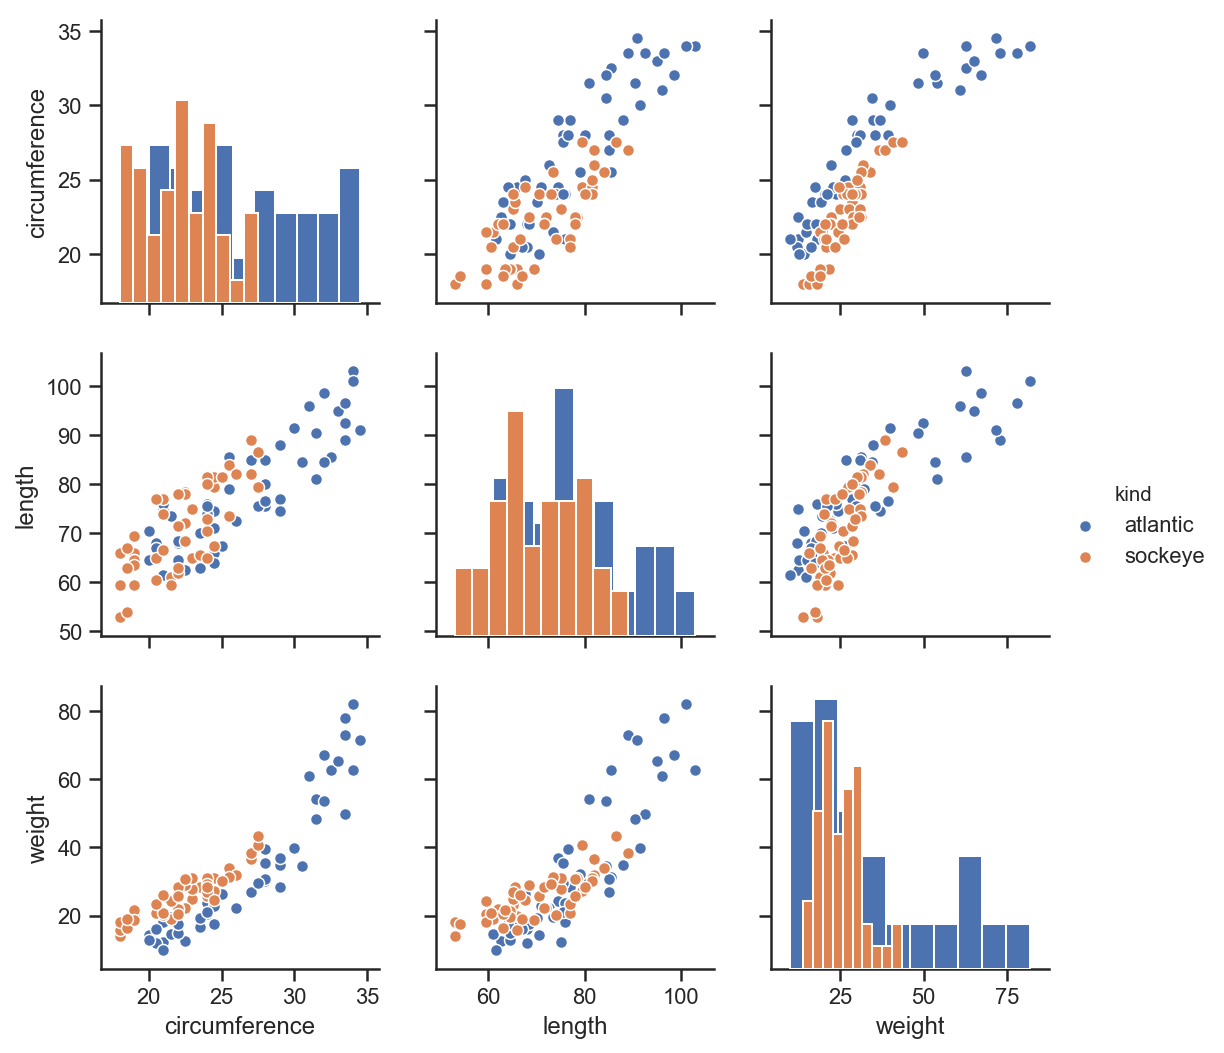

In [5]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df, hue="kind", diag_kind="hist");

In contrast to our previous examples, our data set contains a non-numerical text column `kind`.

<code>sklearn.preprocessing.LabelEncoder</code> is a preprocessor which encodes text values to according numbers:



In [6]:
from sklearn.preprocessing import LabelEncoder

df.iloc[:, 2] = LabelEncoder().fit_transform(df.iloc[:, 2]) 
df.head()

,circumference,length,kind,weight
0,25.5,85.5,0,31.2
1,22.5,62.5,0,12.4
2,29.0,88.0,0,34.8
3,32.5,85.5,0,62.7
4,24.5,74.5,0,24.2


In [7]:
df.tail()

,circumference,length,kind,weight
95,19.0,69.5,1,18.8
96,18.5,67.0,1,18.9
97,24.5,67.5,1,24.7
98,21.0,66.5,1,26.0
99,27.5,86.5,1,43.4


Now we prepare the data for training and testing:

In [8]:
from sklearn.model_selection import train_test_split

features = df.iloc[:, :-1]
values = df.iloc[:, -1]

(features_train, features_test, 
 values_train, 
 values_test) = train_test_split(features, values, random_state=42)

Without further explanation we pick a regression algorithm, more about regrssion algorithms will be discussed later:

In [9]:
from sklearn.kernel_ridge import KernelRidge
kr = KernelRidge(alpha=.1, kernel="rbf", gamma=.1)

<div class="alert alert-block alert-info">
    <i class="fa fa-info-circle"></i>&nbsp; Regression methods in <code>scikit-learn</code> also have <code>fit</code> and <code>predict</code> methods. Thus cross validation, pipelines and hyperparameter-optimization will be available.
    
</div>

In [10]:
kr.fit(features_train, values_train)
predicted = kr.predict(features_test)

Let us plot how good given and predicted values match on the training data set (sic !).

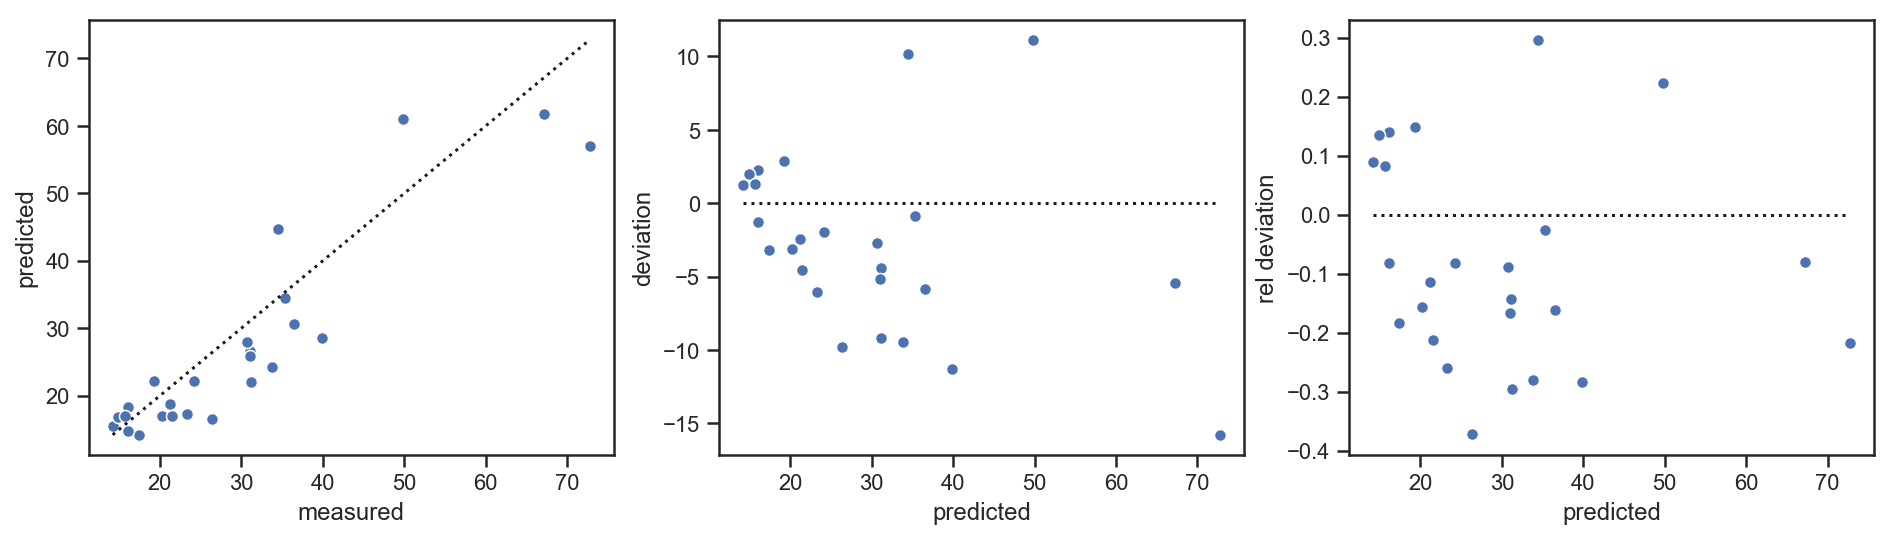

In [12]:
def plot_fit_quality(values_test, predicted):

    mi, ma = min(values_test), max(values_test)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)

    sns.scatterplot(values_test, predicted) 

    plt.plot([mi, ma], [mi, ma], "k:")
    plt.xlabel("measured")
    plt.ylabel("predicted");

    plt.subplot(1, 3, 2)

    sns.scatterplot(values_test, predicted - values_test) 
    plt.plot([mi, ma], [0, 0], "k:")
    plt.xlabel("predicted")
    plt.ylabel("deviation");
    
    plt.subplot(1, 3, 3)

    sns.scatterplot(values_test, (predicted - values_test) / values_test) 
    plt.plot([mi, ma], [0, 0], "k:")
    plt.xlabel("predicted")
    plt.ylabel("rel deviation");
    
    
plot_fit_quality(values_test, predicted)

For assessing the quality of the predictions of a regression method, we can use multiple methods which we will discuss later in this script.

For our current example we compute the average absolute difference between given values $y_i$ and predicted values  $\hat{y}_i$:

$$
\frac{1}{n} \left(\, |y_1 - \hat{y}_1| \, + \, |y_2 - \hat{y}_2| \, + \, \ldots \,+ \,|y_n - \hat{y}_n| \,\right)
$$


In [19]:
import numpy as np

error = np.sum(np.abs(predicted - values_test)) / len(values_test)
print(error)

5.35144698789554


## Metrics / error measures

When we used classification metrics (like accuracy, precision, recall, F1) high values indicated good classification performance. 

Most regression metrics turn this upside down. E.g. smaller values indicate a better regression model.

The hyperparameter optimization functions from `scikit-learn` select configurations which yield a large score. To make regression functions work in this framework, we have to flip the sign of the error value to achieva a usable score.

E.g.

- an average absolute error of 0.1 is scored as -0.1
- an average absolute error of 0.2 is scored as -0.2

In this situation the first case would be prefered: higher score indicates lower error.
   

`scikit-learn` offers the following metrics for measuring regression quality:

### 1. Mean absolute error

This is the metric we used before. Taking absolute values before adding up the deviatons assures that deviations with different signs can not cancel out.

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>mean absolute error</strong> is defined as 


$$
\frac{1}{n} \left(\, |y_1 - \hat{y}_1| \, + \, |y_2 - \hat{y}_2| \, + \, \ldots \,+ \,|y_n - \hat{y}_n| \,\right)
$$


</div>


The name of the corresponding score in `scikit-learn` is `neg_mean_absolute_error`.


### 2. Mean squared error

Here we replace the absolute difference by its squared difference. Squaring also insures positive differeces.


<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>mean squared error</strong> is defined as 



$$
\frac{1}{n} \left(\, (y_1 - \hat{y}_1)^2 \, + \, (y_2 - \hat{y}_2)^2 \, \, \ldots \,+ \,(y_n - \hat{y}_n)^2 \,\right)
$$


</div>



This measure is more sensitive to outliers: A few larger differences contribute more significantly to a larger mean squared error. The name of the corresponding score in `scikit-learn` is `neg_mean_squared_error`.


### 3. Median absolute error

Here we replace mean calculation by median. 

<div class="alert alert-block alert-warning">
    <i class="fa fa-info-circle"></i>&nbsp; <strong>median absolute error</strong> is defined as 



$$
\text{median}\left(\,|y_1 - \hat{y}_1|, \,|y_2 - \hat{y}_2|, \,\ldots, \,|y_n - \hat{y}_n| \, \right)
$$


</div>


This measure is less sensitive to outliers than the metrics we discussed before: A few larger differences will not contribute significantly to a larger error value. The name of the corresponding score in `scikit-learn` is `neg_median_absolute_error`.

### 4. Mean squared log error

The formula for this metric can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error). 

This metric is recommended when your target values are distributed over a huge range of values, like popoluation numbers. 
The previous error metrics would put a larger weight on large target values. One could consider relative deviations to compensate such effects but relative deviations come with other problems like division by zero.


The name is `neg_mean_squared_log_error`


### 5. Explained variance and $r^2$-score

Two other scores to mention are *explained variance* and $r^2$-score. For both larger values indicate better regression results.

The formula for [r2 can be found here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score), the score takes values in the range $0 .. 1$. The name within `scikit-learn` is `r2`.

The formula for [explained variance](https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score), the score takes values up to $1$. The name within `scikit-learn` is `explained_variance`.


## Some algorithms from sklearn

- `sklearn.linear_model.LinearRegression` is a linear regression method, which only works well for target values which can be described as a linear combination of feature values.


- `sklearn.kernel_ridge.KernelRidge` is [documented here](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge). It combines the kernel trick from SVMs with classical least squares regression.


- `sklearn.svm.SVR` is an extension of support vector classification concept to regression, [you find examples here](https://scikit-learn.org/stable/modules/svm.html#svm-regression)


- `sklearn.neighbors.KNeighborsRegressor` extends the idea of nearest neighbour classification to regression: Search for similar data points in the learning data set and compute the predicted value from the values from the neighbourhood, e.g. by averaging or by linear interpolation. [Documentation is available here](https://scikit-learn.org/stable/modules/neighbors.html#regression)


- `sklearn.tree.DecisionTreeRegressor` expands the concept of decision trees to regression [is documented here](https://scikit-learn.org/stable/modules/tree.html#regression).




## A full pipeline

Let us now try to find a good regressor using `scikit-learn`s hyper-parameter tuning:

cross val score: -5.912462522846011


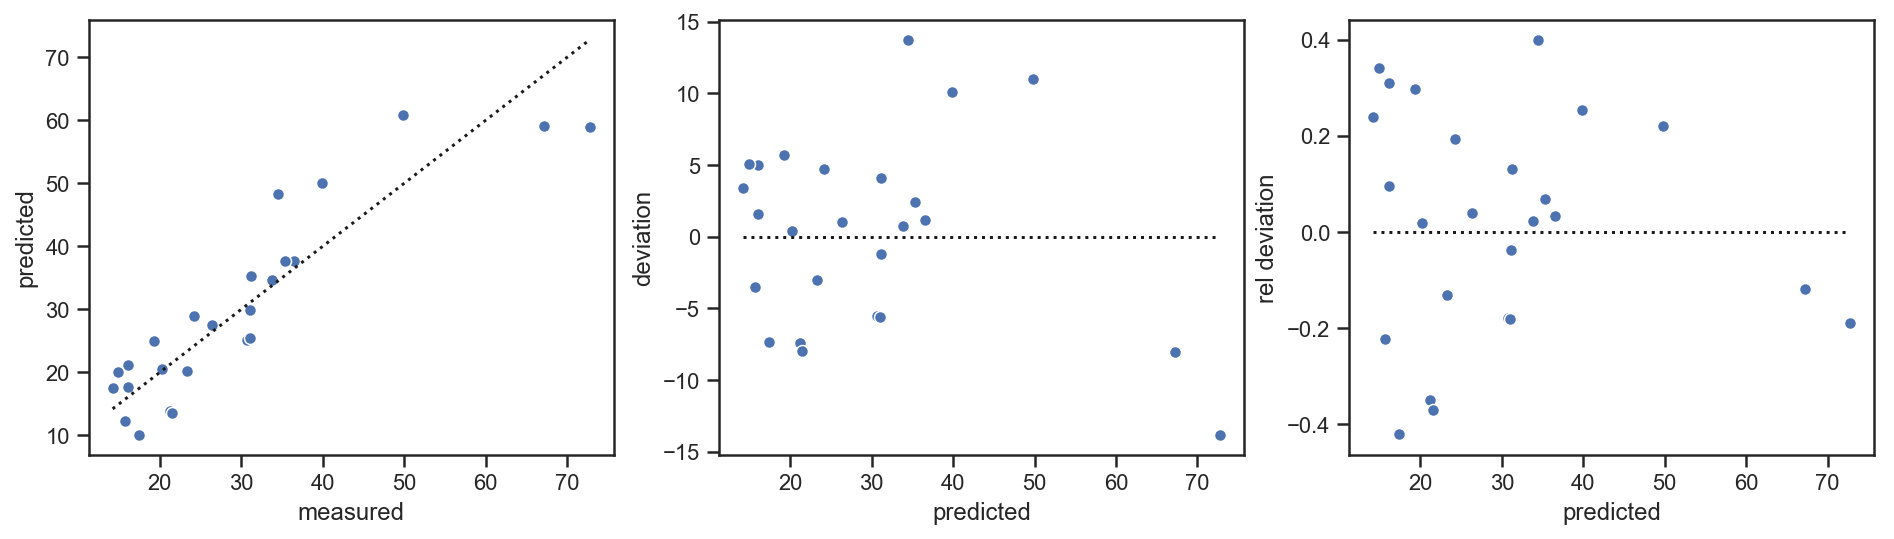

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA


def eval_regression(p):
    score = cross_val_score(p, features, values, scoring="neg_median_absolute_error", cv=4).mean()
    print("cross val score:", score)
  
    predicted = p.fit(features_train, values_train).predict(features_test)
    plot_fit_quality(values_test, predicted)

    
p = make_pipeline(PolynomialFeatures(2), PCA(2), LinearRegression())
eval_regression(p)

In [20]:
p = make_pipeline(PolynomialFeatures(), PCA(), LinearRegression())

param_grid = {'polynomialfeatures__degree': range(3, 6),
              'pca__n_components': range(3, 13),
             }

{'pca__n_components': 12, 'polynomialfeatures__degree': 3}
cross val score: -2.4183828298404433


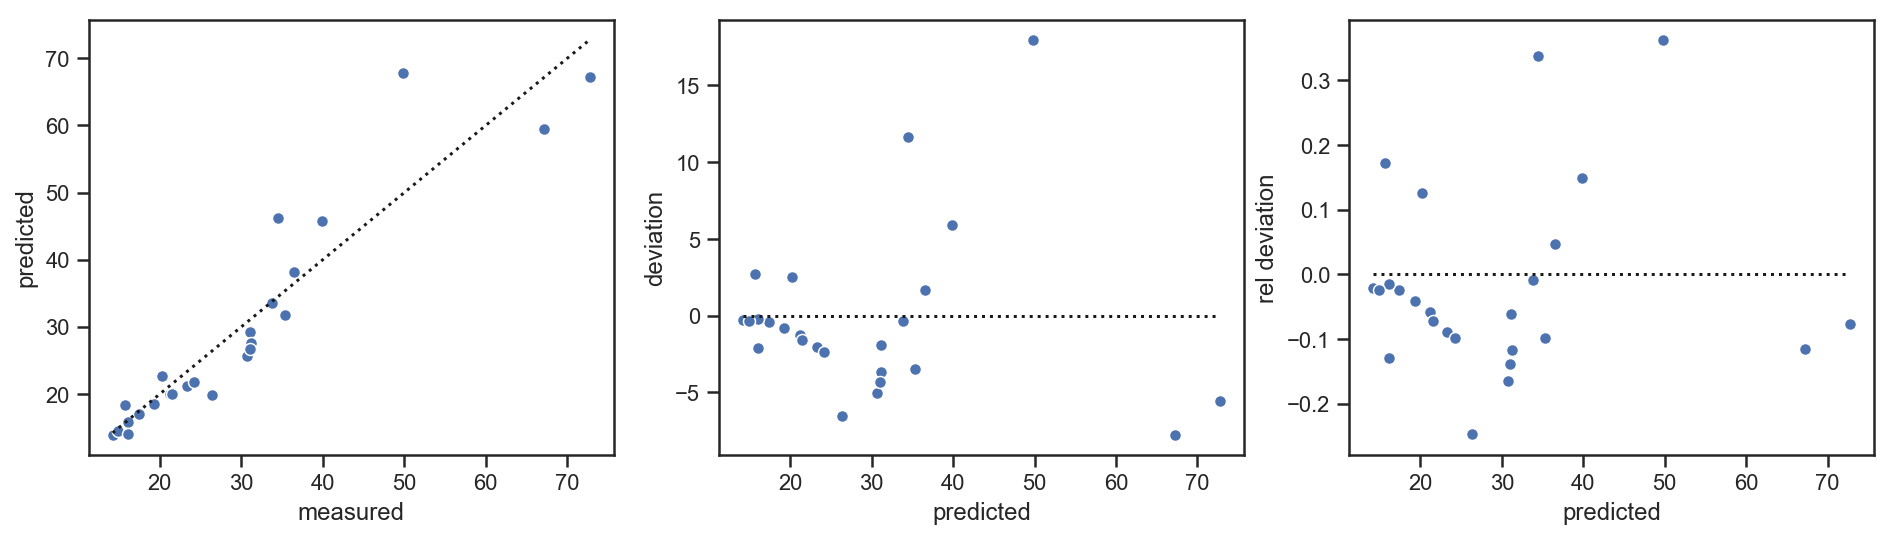

In [21]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(p, param_grid, scoring="neg_median_absolute_error", cv=4, n_jobs=4)

search.fit(features, values)


print(search.best_params_)
eval_regression(search)

# Exercise section

- Play with the examples above and try different algorithms, metrics and pipelines.


## Optional exercise

- Split the dataset into one with `kind="sockeye"` and one with `kind="atlantic"` and build individual regression models for both. How does this approach compare to the results we got before ?